<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Salt-Identification-Image-Segmentation-/blob/main/Salt_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from tqdm.auto import tqdm, trange
from itertools import chain

import cv2
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import models, Input, layers, callbacks, utils, optimizers

from keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# ! unzip "/content/drive/MyDrive/Salt_Identification_Kaggle/data/train.zip" -d "/content/drive/MyDrive/Salt_Identification_Kaggle/data/train/"
# ! unzip -q "/content/drive/MyDrive/Salt_Identification_Kaggle/data/test.zip" -d "/content/drive/MyDrive/Salt_Identification_Kaggle/data/test/"

In [3]:
train_path = "/content/drive/MyDrive/Salt_Identification_Kaggle/data/train/"
test_path = "/content/drive/MyDrive/Salt_Identification_Kaggle/data/test/"

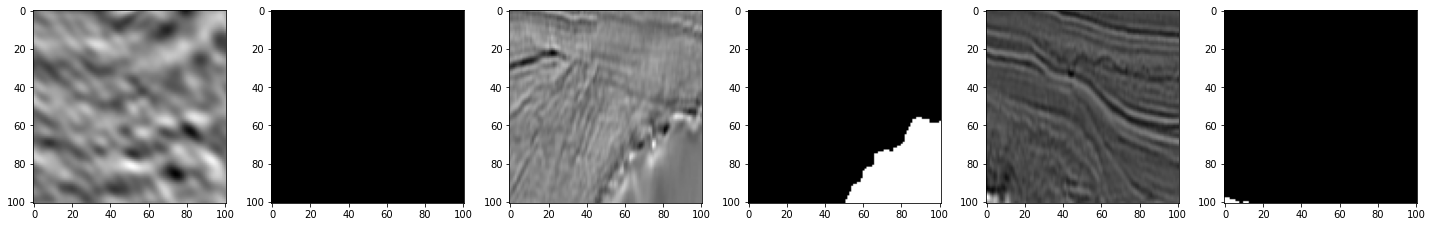

In [4]:
tf.random.set_seed(19)
imgs = np.random.choice(os.listdir('/content/drive/MyDrive/Salt_Identification_Kaggle/data/train/images/'), 3)
fig = plt.figure(figsize=(20,6))
for i, img_name in enumerate(imgs):
    j = i+1
    
    img = load_img('/content/drive/MyDrive/Salt_Identification_Kaggle/data/train/images/' + img_name)
    img_mask = load_img('/content/drive/MyDrive/Salt_Identification_Kaggle/data/train/masks/' + img_name)
    
    plt.subplot(1, 6, j*2-1)
    plt.imshow(img)
    plt.subplot(1, 6, j*2)
    plt.imshow(img_mask)
plt.tight_layout()


In [5]:
# next(os.walk(train_path+"images"))[2] == os.listdir(train_path + "images")

In [4]:
train_ids = os.listdir(train_path+"images")
test_ids = os.listdir(test_path+"images")

In [5]:
len(train_ids), len(test_ids)

(4000, 18000)

In [6]:
np.array(load_img(train_path+"images/"+train_ids[0])).shape

(101, 101, 3)

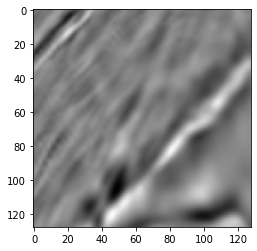

In [7]:
plt.imshow(cv2.resize(np.array(load_img(train_path+"images/"+train_ids[0])), (128,128)))

In [8]:
img_to_array(load_img(train_path+"images/"+train_ids[0])).dtype

dtype('float32')

In [14]:
tf.reduce_sum(x)/len(x), tf.reduce_sum(y)/len(y)

(<tf.Tensor: shape=(), dtype=float64, numpy=101.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=101.0>)

In [11]:
# Load and preprocess images and masks
# X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
# Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
X_train = []
y_train = []

# print('Getting and resizing train images and masks ... ')
# sys.stdout.flush()
for n, id in tqdm(enumerate(train_ids)):
    img = load_img(train_path + '/images/' + id)
    x = img_to_array(img)
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train.append(x)
    mask_img = load_img(train_path + '/masks/' + id)
    y = img_to_array(mask_img)
    y = resize(y, (128, 128, 1), mode='constant', preserve_range=True)
    y_train.append(y)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
# np.save('/content/drive/MyDrive/Salt_Identification_Kaggle/data/X_train_np.npy', X_train)
# np.save('/content/drive/MyDrive/Salt_Identification_Kaggle/data/y_train_np.npy', y_train)

In [78]:
X_train = np.load('/content/drive/MyDrive/Salt_Identification_Kaggle/data/X_train_np.npy')
y_train = np.load('/content/drive/MyDrive/Salt_Identification_Kaggle/data/y_train_np.npy')
X_train /= 255
y_train /= 255
X_train.shape, y_train.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

In [17]:
X_train.shape, type(X_train)

((4000, 128, 128, 1), numpy.ndarray)

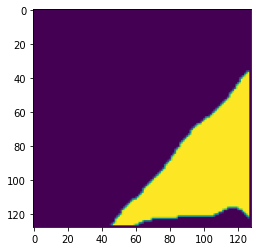

In [71]:
plt.imshow(tf.squeeze(y_train[0]))

In [ ]:
type(x), type(y)

(numpy.ndarray, numpy.ndarray)

In [54]:
np.min(y_train[0]/255), np.max(y_train[0]/255)

(0.0, 0.88288635)

In [60]:
np.any(np.isnan([X_train[i] for i in range(len(X_train))]))

False

In [ ]:
np.array(x).shape, np.array(y).shape

((128, 128, 1), (128, 128, 1))

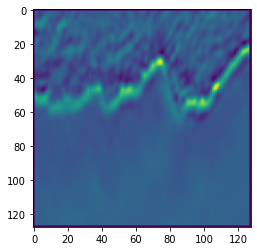

In [ ]:
plt.imshow(X_train[1][:,:,0])

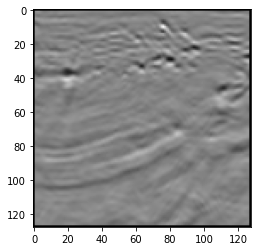

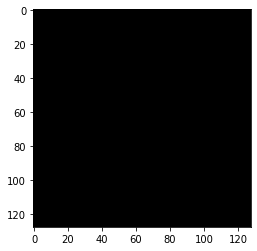

In [ ]:
# Visualize data
ix = np.random.randint(0, len(train_ids))
temp_1 = np.squeeze(X_train[ix])
plt.imshow(temp_1, cmap = 'gray')
plt.show()
temp_2 = np.squeeze(y_train[ix])
plt.imshow(temp_2, cmap = 'gray')
plt.show()

In [52]:

# def e_mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred = tf.cast(y_pred > t, tf.int32)
#         score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

# def get_iou_vector(A, B):
#     batch_size = A.shape[0]
#     metric = []
#     for batch in range(batch_size):
#         t, p = A[batch]>0, B[batch]>0
# #         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
# #             metric.append(0)
# #             continue
# #         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
# #             metric.append(0)
# #             continue
# #         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
# #             metric.append(1)
# #             continue
        
#         intersection = np.logical_and(t, p)
#         union = np.logical_or(t, p)
#         iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
#         thresholds = np.arange(0.5, 1, 0.05)
#         s = []
#         for thresh in thresholds:
#             s.append(iou > thresh)
#         metric.append(np.mean(s))

#     return np.mean(metric)

# def my_iou_metric(label, pred):
#     return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


In [11]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

In [131]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.0001), loss='binary_crossentropy', metrics=['acc'])
model.summary()




Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 128, 128, 16) 160         input_11[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 128, 128, 16) 0           conv2d_144[0][0]                 
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 128, 128, 16) 2320        dropout_36[0][0]                 
____________________________________________________________________________________________

## Defining Callbacks

In [133]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Salt_Identification_Kaggle/models/unet_dropout_each_1.h5', verbose=1, save_best_only=True)

earlystopper = tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_loss')
tensorboard_logger = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Salt_Identification_Kaggle/logs/')

In [160]:
# Build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)

c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2)) (c1)

c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2)) (c2)

c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2)) (c3)

c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001), 
              loss='binary_crossentropy', 
              metrics=['acc'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 128, 128, 8)  80          input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 128, 128, 8)  584         conv2d_182[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_183[0][0]                 
____________________________________________________________________________________________

In [209]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
# c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3 = tf.keras.layers.Dropout(0.2)(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
# c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.0001), loss='binary_crossentropy', metrics=['acc'])
model.summary()




Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 128, 128, 16) 160         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 128, 128, 16) 2320        conv2d_220[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 64, 64, 16)   0           conv2d_221[0][0]                 
___________________________________________________________________________________________

In [210]:
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer, tensorboard_logger])

Epoch 1/50
225/225 [==============================] - 7s 27ms/step - loss: 0.5778 - acc: 0.6480 - val_loss: 0.4021 - val_acc: 0.7497

Epoch 00001: val_loss did not improve from 0.20929
Epoch 2/50
225/225 [==============================] - 5s 22ms/step - loss: 0.3990 - acc: 0.7278 - val_loss: 0.3429 - val_acc: 0.7432

Epoch 00002: val_loss did not improve from 0.20929
Epoch 3/50
225/225 [==============================] - 5s 22ms/step - loss: 0.3545 - acc: 0.7227 - val_loss: 0.3101 - val_acc: 0.7431

Epoch 00003: val_loss did not improve from 0.20929
Epoch 4/50
225/225 [==============================] - 5s 22ms/step - loss: 0.3207 - acc: 0.7265 - val_loss: 0.3098 - val_acc: 0.7535

Epoch 00004: val_loss did not improve from 0.20929
Epoch 5/50
225/225 [==============================] - 5s 22ms/step - loss: 0.3107 - acc: 0.7288 - val_loss: 0.2852 - val_acc: 0.7343

Epoch 00005: val_loss did not improve from 0.20929
Epoch 6/50
225/225 [==============================] - 5s 22ms/step - loss: 

In [232]:
model = load_model('/content/drive/MyDrive/Salt_Identification_Kaggle/models/unet_dropout_each_1.h5')

In [21]:
# Load and preprocess test images
X_test = []

# print('Getting and resizing test images and masks ... ')
# sys.stdout.flush()
for n, id in tqdm(enumerate(test_ids)):
    img = load_img(test_path + '/images/' + id)
    x = img_to_array(img)
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test.append(x)
X_test = np.array(X_test)
np.save('/content/drive/MyDrive/Salt_Identification_Kaggle/data/X_test_np.npy',X_test)

In [233]:
X_test = np.load('/content/drive/MyDrive/Salt_Identification_Kaggle/data/X_test_np.npy')
X_test /= 255

In [234]:
# Predict on train, val and test
# loaded_model = load_model('') #, custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


563/563 [==============================] - 5s 9ms/step


In [235]:
X_val = X_train[int(X_train.shape[0]*0.9):]
y_val = y_train[int(y_train.shape[0]*0.9):]

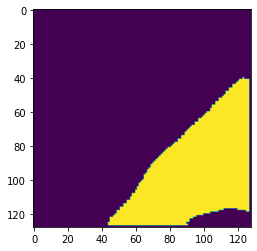

In [236]:
plt.imshow(tf.squeeze(preds_train_t[0]))

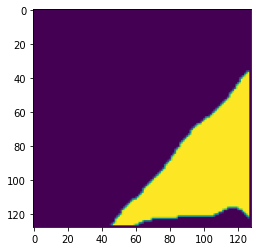

In [237]:
plt.imshow(tf.squeeze(y_train[0]))

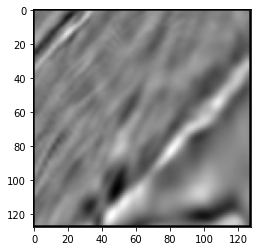

In [238]:
plt.imshow(tf.squeeze(X_train[0]), cmap = 'gray')

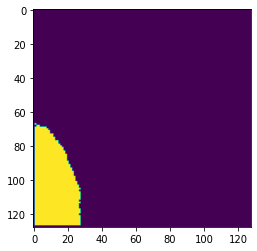

In [239]:
plt.imshow(tf.squeeze(preds_test_t[0]))

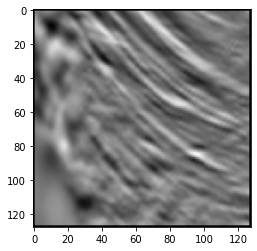

In [240]:
plt.imshow(tf.squeeze(X_test[0]), cmap = 'gray')

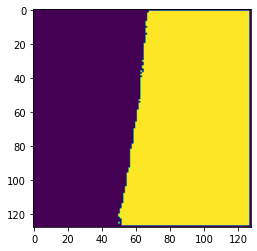

In [241]:
plt.imshow(tf.squeeze(preds_val_t[2]))

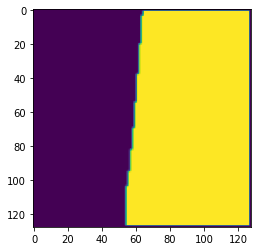

In [242]:
plt.imshow(tf.squeeze(y_val[2]))

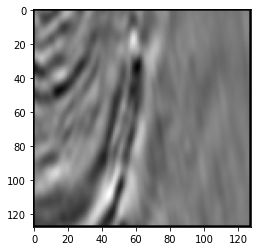

In [243]:
plt.imshow(tf.squeeze(X_val[2]), cmap = 'gray')

In [244]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [245]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_val, np.int32(preds_val > threshold)) 
                  for threshold in tqdm(thresholds)])

In [246]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]


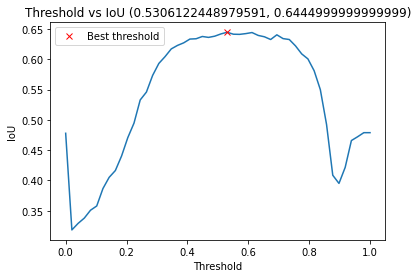

In [247]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Getting ready for submission

In [248]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs


In [249]:
sub_ids = [i.split('.')[0] for i in test_ids]

In [250]:
len(sub_ids)

18000

In [251]:
ORIGINAL_SIZE = 101
TARGET_SIZE = 128
def downsample(img):
    if ORIGINAL_SIZE == TARGET_SIZE:
        return img
    return resize(img, (ORIGINAL_SIZE, ORIGINAL_SIZE), mode='constant', preserve_range=True)

In [252]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best))
            for i, idx in enumerate(tqdm(sub_ids))}

In [253]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [254]:
sub.to_csv('/content/drive/MyDrive/Salt_Identification_Kaggle/submissions/submission_5_es.csv')